### Sıfırdan başlamak için açtım


# Imports % Pip installs


In [ ]:
!pip install yfinance --quiet

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from google.colab import files
import pandas as pd
import datetime
import time
import yfinance as yf
import matplotlib.pyplot as plt

# Data Processing


In [ ]:
# Deneme datayı alıyoruz
prices = pd.read_csv("10bin-row-Denemelik-2025-02-06.csv")  # Placeholder for your dataset
prices.set_index('Timestamp', inplace=True)

In [ ]:
# Scaling
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(prices)

# ✅ Convert back to DataFrame
scaled_prices = pd.DataFrame(scaled_prices, columns=prices.columns, index=prices.index)

look_back = 240  # Use 50 past candles as input
future_step = 1

X, y = [], []
for i in range(len(scaled_prices) - look_back - future_step):
    X.append(scaled_prices.iloc[i : i + look_back].values)  # Collect 240 timesteps
    y.append(scaled_prices.iloc[i + look_back + future_step - 1]["Close"])  # Close at t+1

# Convert to NumPy arrays
X = np.array(X)  # Shape: (samples, 50, 5)
y = np.array(y)  # Shape: (samples,)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
# Checking the data shape
print(f"After reshaping: X_train shape = {X_train.shape}")  # (N, 1, 4) --> Correct shape
print(f"After reshaping: X_test shape = {X_test.shape}")  # (N, 1, 4) --> Correct shape
print(f"After reshaping: y_train shape = {y_train.shape}")  # (N, 1, 4) --> Correct shape
print(f"After reshaping: y_test shape = {y_test.shape}")  # (N, 1, 4) --> Correct shape

After reshaping: X_train shape = (7807, 240, 5)
After reshaping: X_test shape = (1952, 240, 5)
After reshaping: y_train shape = (7807,)
After reshaping: y_test shape = (1952,)


# Fonks

In [ ]:
def produce_predictions(model,scaled_prices):
    y_pred = model.predict(X_test)
    df_pre =  pd.DataFrame(columns=["timestamp","p_price", "r_price"])
    X_test_indices = scaled_prices.index[-len(X_test):]
    for i in range(len(y_pred)):
      y_pred_inv = scaler.inverse_transform(
      [[0, y_pred[i][0], 0, 0, 0]]
      )[0][1]
      y_test_inv = scaler.inverse_transform(
      [[0, y_test[i], 0, 0, 0]]
      )[0][1]
      new_row = pd.DataFrame([{"timestamp":X_test_indices[i], "p_price": y_pred_inv, "r_price": y_test_inv}])
      # Use pd.concat() to add the new row
      df_pre = pd.concat([df_pre, new_row], ignore_index=True)

    return df_pre

In [ ]:
def plotting_predictions(df_pre, filename):
  # Convert timestamp to datetime (if not already done)
  df_pre['timestamp'] = pd.to_datetime(df_pre['timestamp'])

  # Create a line plot
  plt.figure(figsize=(12, 6))
  plt.plot( df_pre['timestamp'], df_pre['p_price'], label='Predicted Price (pre_price)', color='blue', marker='o', markersize=4)
  plt.plot(df_pre['timestamp'], df_pre['r_price'], label='Real Price (real_price)', color='red', marker='o', markersize=4)

  # Customize the axes and figure background
  ax = plt.gca()
  ax.set_facecolor('black')  # Set axes' background to black
  ax.tick_params(axis='both', colors='black')  # Set tick marks and labels to white
  ax.xaxis.label.set_color('white')  # Set x-axis label to white
  ax.yaxis.label.set_color('white')  # Set y-axis label to white
  ax.title.set_color('black')  # Set title color to white
  # Add labels and title
  plt.xlabel('Timestamp')
  plt.ylabel('Price')
  plt.title('Predicted vs Real Price Over Time')
  plt.legend()
  plt.grid(True)

  # Rotate x-axis labels for better readability
  plt.xticks(rotation=45)

  # Show the plot
  plt.tight_layout()

  plt.savefig(filename, format='png')  # Change the format if needed, e.g., 'jpg', 'svg'

  files.download(filename)  # This will prompt you to download the file


  plt.show()

# Build Models


## Model_6   / loss: 2.8930e-05/ 3.936385110137053e-05


3 Layers;
**LSTM** (64, input_shape=(lookback(240), 5), return_sequences=True),
**LSTM** (32),
**Dense** (1),

In [ ]:
model_6 = Sequential([
    LSTM(64, return_sequences=True, input_shape=(240, 5)),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
], name = 'model_6')
model_6.compile(optimizer='adam', loss='mse')
# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_6 = model_6.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
854/854 ━━━━━━━━━━━━━━━━━━━━ 224s 255ms/step - loss: 0.0099 - val_loss: 2.3417e-04
Epoch 2/50
854/854 ━━━━━━━━━━━━━━━━━━━━ 260s 253ms/step - loss: 0.0023 - val_loss: 0.0012
Epoch 3/50
854/854 ━━━━━━━━━━━━━━━━━━━━ 238s 225ms/step - loss: 0.0014 - val_loss: 2.9761e-04
Epoch 4/50
854/854 ━━━━━━━━━━━━━━━━━━━━ 221s 247ms/step - loss: 9.5434e-04 - val_loss: 3.3685e-04
Epoch 5/50
854/854 ━━━━━━━━━━━━━━━━━━━━ 202s 236ms/step - loss: 7.0052e-04 - val_loss: 2.7798e-04
Epoch 6/50
854/854 ━━━━━━━━━━━━━━━━━━━━ 203s 237ms/step - loss: 5.8514e-04 - val_loss: 1.2174e-04
Epoch 7/50
854/854 ━━━━━━━━━━━━━━━━━━━━ 259s 233ms/step - loss: 5.6018e-04 - val_loss: 4.9353e-05
Epoch 8/50
854/854 ━━━━━━━━━━━━━━━━━━━━ 197s 228ms/step - loss: 5.8940e-04 - val_loss: 1.4571e-04
Epoch 9/50
854/854 ━━━━━━━━━━━━━━━━━━━━ 201s 236ms/step - loss: 5.6093e-04 - val_loss: 3.7768e-05
Epoch 10/50
854/854 ━━━━━━━━━━━━━━━━━━━━ 198s 231ms/step - loss: 5.4312e-04 - val_loss: 3.4462e-05
Epoch 11/50
854/854 ━━━━━━━━━━━━━━━

In [ ]:
model_1.evaluate(X_test,y_test)

237/237 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - loss: 2.8930e-05


3.936385110137053e-05

### Predict and plot

237/237 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step


<ipython-input-15-d7e28bd45f6e>:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_pre = pd.concat([df_pre, new_row], ignore_index=True)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

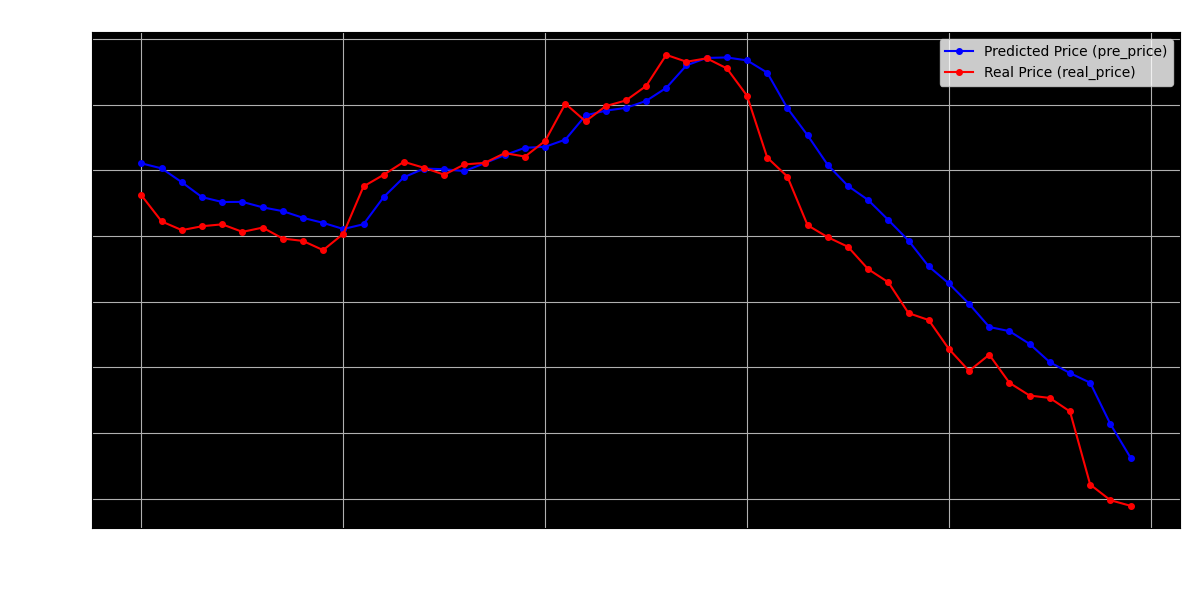

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

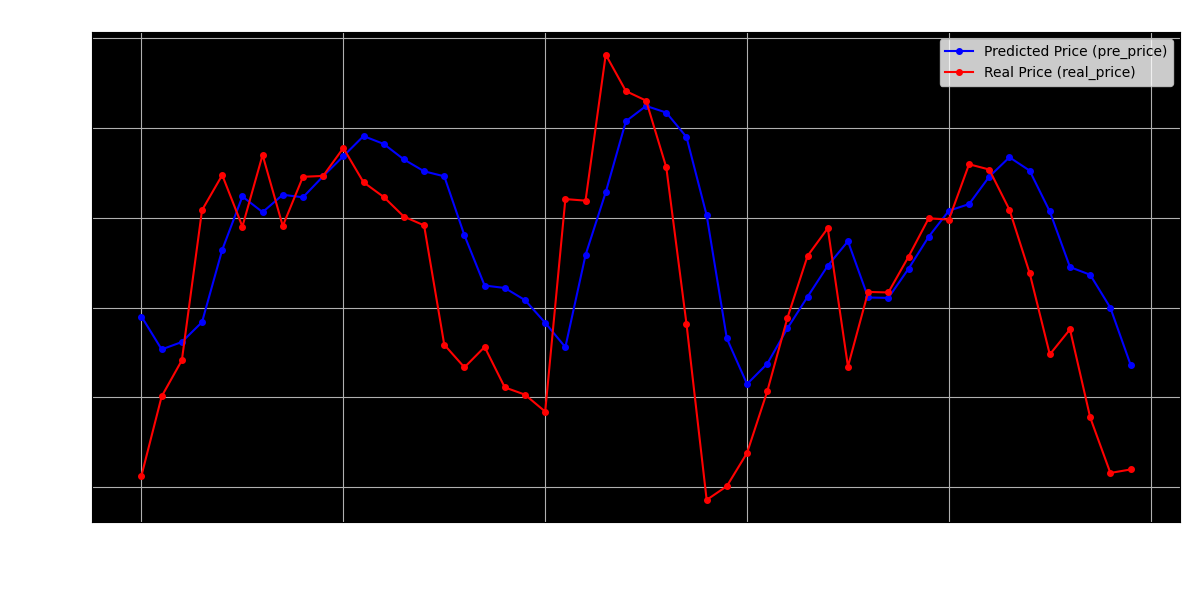

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

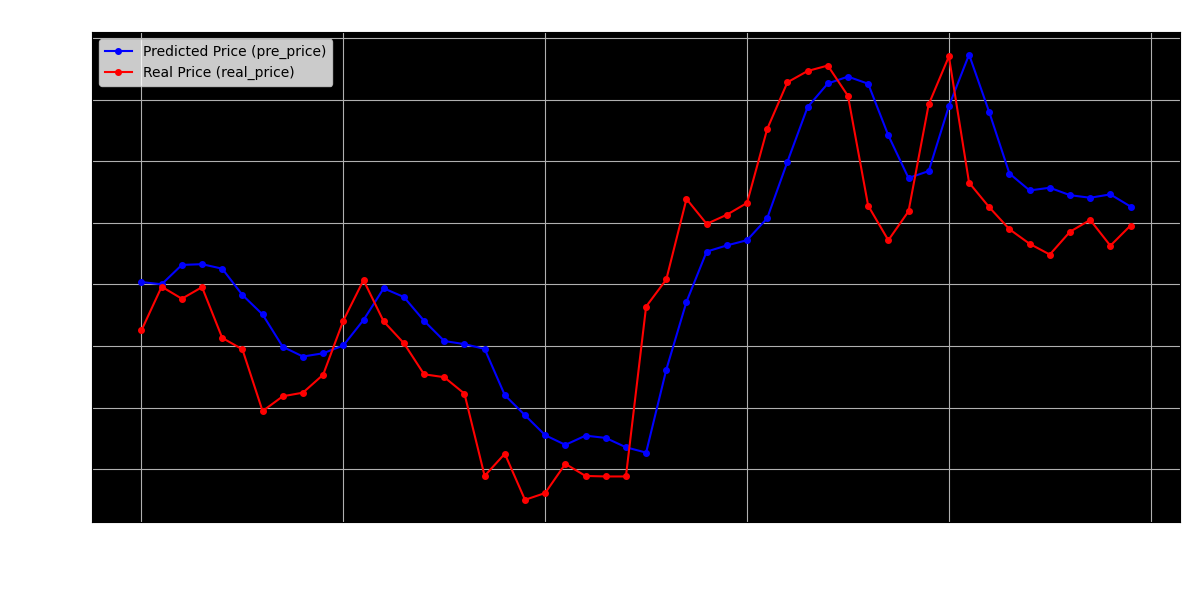

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

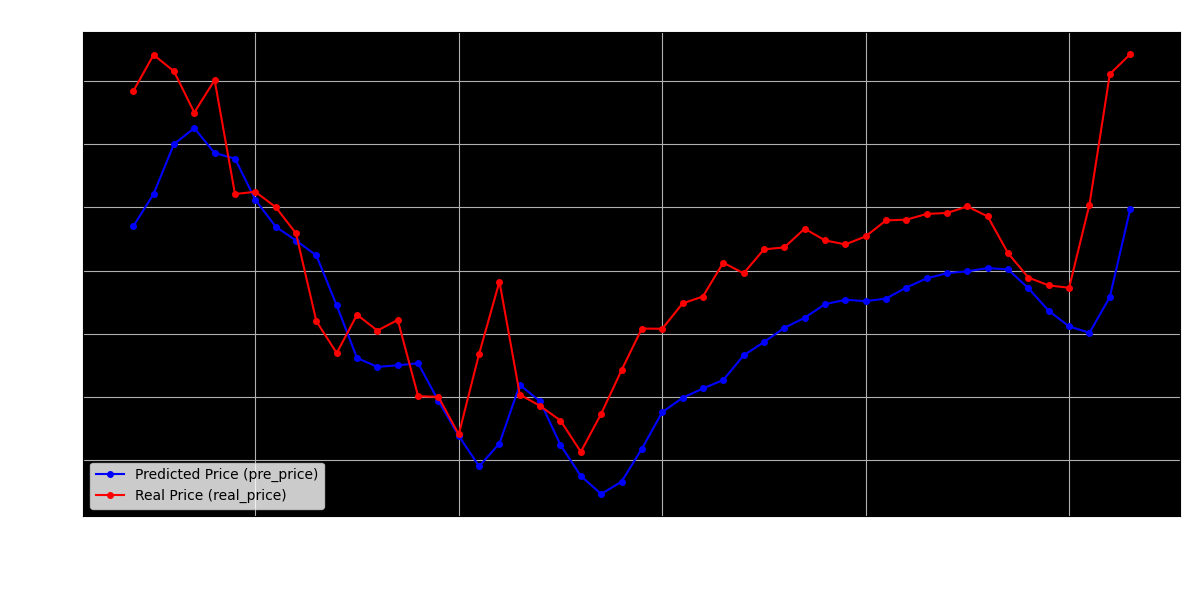

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

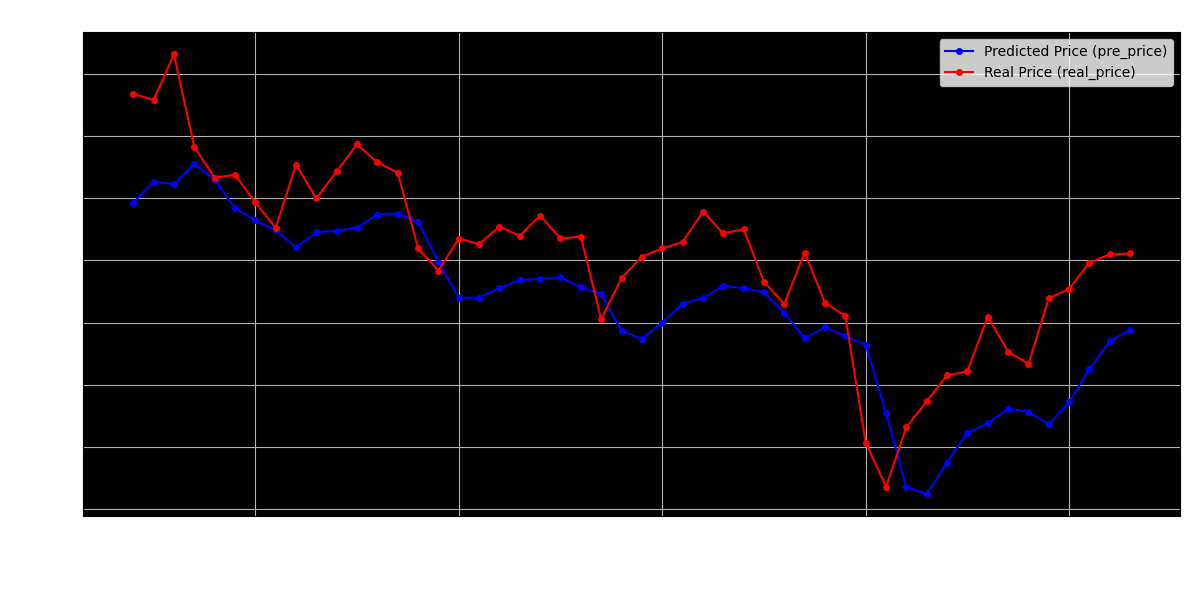

In [ ]:
df_pre_6 = produce_predictions(model_1)
plotting_predictions(df_pre_6[:50],"model_6.png")
plotting_predictions(df_pre_6[50:100],"model_6.png")
plotting_predictions(df_pre_6[100:150],"model_6.png")
plotting_predictions(df_pre_6[-100:-50],"model_6.png")
plotting_predictions(df_pre_6[-50:],"model_6.png")

## Model_7 // loss: 9.7479e-05 / 0.00011922269914066419

Geçen ki model_5 'in farklı hali


`4 Layers;`
**LSTM** (64, input_shape=(lookback(240), 5), return_sequences=True, activation='tanh),
Dropout(0.2),
**LSTM** (32, return_sequences=False, activation='tanh'),
Dropout(0.2),
**Dense** (10, activation='relu')
**Dense** (1),

`Optimezer = Adam(0.01)`

In [ ]:
model_7 = Sequential([
    LSTM(64, return_sequences=True, input_shape=(240, 5), activation='tanh'),
    Dropout(0.2),
    LSTM(32, return_sequences=False, activation='tanh'),
    Dropout(0.2),
    Dense(10, activation='relu'),
    Dense(1)
],name="model_7")
model_7.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')
# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_7 = model_7.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop]
)

## Model_8   / loss: 9.2119e-05 / 0.00010770310473162681



`4 Layers;`
**LSTM** (64, input_shape=(lookback(240), 5), return_sequences=True, activation='tanh),
Dropout(0.2),
**LSTM** (32, return_sequences=False, activation='tanh'),
Dropout(0.2),
**Dense** (10, activation='relu')
**Dense** (1),


The only change here is ;
**`Optimizer = Adam(0.001)`**

In [ ]:
model_8 = Sequential([
    LSTM(64, return_sequences=True, input_shape=(240, 5), activation='tanh'),
    Dropout(0.2),
    LSTM(32, return_sequences=False, activation='tanh'),
    Dropout(0.2),
    Dense(10, activation='relu'),
    Dense(1)
],name="model_8")
model_8.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_8 = model_8.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop]
)

## Model_9  / loss: 1.6801e-05 / 2.1539464796660468e-05
The only change here is ; removing dropouts .

`4 Layers;`
**LSTM** (64, input_shape=(lookback(240), 5), return_sequences=True, activation='tanh),
**LSTM** (32, return_sequences=False, activation='tanh'),
**Dense** (10, activation='relu')
**Dense** (1),



**`Optimizer = Adam(0.001)`**

In [ ]:
model_9 = Sequential([
    LSTM(64, return_sequences=True, input_shape=(240, 5), activation='tanh'),
    LSTM(32, return_sequences=False, activation='tanh'),
    Dense(10, activation='relu'),
    Dense(1)
],name="model_9")
model_9.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_9.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/50
854/854 ━━━━━━━━━━━━━━━━━━━━ 197s 224ms/step - loss: 0.0031 - val_loss: 7.1154e-05
Epoch 2/50
854/854 ━━━━━━━━━━━━━━━━━━━━ 196s 217ms/step - loss: 1.0268e-04 - val_loss: 5.7525e-05
Epoch 3/50
854/854 ━━━━━━━━━━━━━━━━━━━━ 186s 218ms/step - loss: 8.4580e-05 - val_loss: 3.7269e-05
Epoch 4/50
854/854 ━━━━━━━━━━━━━━━━━━━━ 185s 216ms/step - loss: 7.0649e-05 - val_loss: 3.5228e-05
Epoch 5/50
854/854 ━━━━━━━━━━━━━━━━━━━━ 202s 217ms/step - loss: 6.5400e-05 - val_loss: 3.3935e-05
Epoch 6/50
854/854 ━━━━━━━━━━━━━━━━━━━━ 201s 215ms/step - loss: 5.7606e-05 - val_loss: 8.4655e-05
Epoch 7/50
854/854 ━━━━━━━━━━━━━━━━━━━━ 203s 217ms/step - loss: 5.4087e-05 - val_loss: 2.8077e-04
Epoch 8/50
854/854 ━━━━━━━━━━━━━━━━━━━━ 185s 217ms/step - loss: 5.5024e-05 - val_loss: 4.1450e-05
Epoch 9/50
854/854 ━━━━━━━━━━━━━━━━━━━━ 202s 217ms/step - loss: 3.9046e-05 - val_loss: 1.9885e-05
Epoch 10/50
854/854 ━━━━━━━━━━━━━━━━━━━━ 205s 222ms/step - loss: 3.2081e-05 - val_loss: 3.9366e-05
Epoch 11/50
854/854 ━━━

In [ ]:
model_9.evaluate(X_test,y_test)

237/237 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - loss: 1.6801e-05


2.1539464796660468e-05

### predict


In [ ]:
df_pre_6 = produce_predictions(model_9)
plotting_predictions(df_pre_6[:50],"model_9.png")
plotting_predictions(df_pre_6[50:100],"model_9.png")
plotting_predictions(df_pre_6[100:150],"model_9.png")
plotting_predictions(df_pre_6[-100:-50],"model_9.png")
plotting_predictions(df_pre_6[-50:],"model_9.png")

## Model_10 / loss: 2.1994e-05 - 2.5263252609875053e-05
The only change here is ;
Adding Units do dense layer : 50

`4 Layers;`
**LSTM** (64, input_shape=(lookback(240), 5), return_sequences=True, activation='tanh),
**LSTM** (32, return_sequences=False, activation='tanh'),
**Dense** (50, activation='relu')
**Dense** (1),



**`Optimizer = Adam(0.001)`**

In [ ]:
model_10 = Sequential([
    LSTM(64, return_sequences=True, input_shape=(240, 5), activation='tanh'),
    LSTM(32, return_sequences=False, activation='tanh'),
    Dense(50, activation='relu'),
    Dense(1)
],name="model_10")
model_10.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')
# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_7 = model_10.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop]
)

## Model_11 / loss: 2.1088e-05 2.41966154135298e-05

The only change here is ;
Adding Units to first LSTM layer : 100

`4 Layers;`
**LSTM** (64, input_shape=(lookback(240), 5), return_sequences=True, activation='tanh),
**LSTM** (32, return_sequences=False, activation='tanh'),
**Dense** (50, activation='relu')
**Dense** (1),



**`Optimizer = Adam(0.001)`**

In [ ]:
model_11 = Sequential([
    LSTM(100, return_sequences=True, input_shape=(240, 5), activation='tanh'),
    LSTM(32, return_sequences=False, activation='tanh'),
    Dense(10, activation='relu'),
    Dense(1)
],name="model_11")
model_11.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model_11.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop]
)

## Model_12
**Logic:** I send 240 * 5 data each time for first layer
So let's `first layer` to `240`

`4 Layers;`
**LSTM** (64, input_shape=(lookback(240), 5), return_sequences=True, activation='tanh),
**LSTM** (32, return_sequences=False, activation='tanh'),
**Dense** (50, activation='relu')
**Dense** (1),



**`Optimizer = Adam(0.001)`**

In [ ]:
model_12 = Sequential([
    LSTM(240, return_sequences=True, input_shape=(240, 5), activation='tanh'),
    LSTM(32, return_sequences=False, activation='tanh'),
    Dense(10, activation='relu'),
    Dense(1)
],name="model_12")
model_12.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model_12.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 176s 781ms/step - loss: 0.0219 - val_loss: 2.7422e-04
Epoch 2/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 205s 797ms/step - loss: 1.7420e-04 - val_loss: 3.2825e-04
Epoch 3/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 191s 747ms/step - loss: 1.7938e-04 - val_loss: 3.1502e-04
Epoch 4/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 202s 748ms/step - loss: 1.5955e-04 - val_loss: 3.5282e-04
Epoch 5/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 204s 759ms/step - loss: 1.7353e-04 - val_loss: 2.1745e-04
Epoch 6/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 201s 756ms/step - loss: 1.4042e-04 - val_loss: 2.4707e-04
Epoch 7/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 208s 784ms/step - loss: 1.6110e-04 - val_loss: 2.3515e-04
Epoch 8/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 225s 892ms/step - loss: 1.3337e-04 - val_loss: 1.9234e-04
Epoch 9/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 185s 839ms/step - loss: 1.3788e-04 - val_loss: 2.0743e-04
Epoch 10/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 196s 816ms/step - loss: 1.2657e-04 - val_loss: 1.8379e-04
Epoch 11/50
220/220 ━━━

### Predict


In [ ]:
df_pre_6 = produce_predictions(model_12)
for i in range(0, 500, 100):
  plotting_predictions(df_pre_6[i:i+100], f"model_12-{i}.png")


## Model_13 /  loss: 1.9813e-05 - 2.3184873498394154e-05
Reducing all layers down. to input columns.
`4 Layers;`
**LSTM** (5, input_shape=(lookback(240), 5), return_sequences=True, activation='tanh),
**LSTM** (5, return_sequences=False, activation='tanh'),
**Dense** (5, activation='relu')
**Dense** (1),



**`Optimizer = Adam(0.001)`**

In [ ]:
model_13 = Sequential([
    LSTM(5, return_sequences=True, input_shape=(240, 5), activation='tanh'),
    LSTM(5, return_sequences=False, activation='tanh'),
    Dense(5, activation='relu'),
    Dense(1)
],name="model_13")
model_13.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')
# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model_13.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop]
)

## Model_14 / loss: 2.0543e-05 - 2.3947486624820158e-05

Keep experimenting with reduced layers being increased little by little

`4 Layers;`
**LSTM** (10, input_shape=(lookback(240), 5), return_sequences=True, activation='tanh),
**LSTM** (10, return_sequences=False, activation='tanh'),
**Dense** (10, activation='relu')
**Dense** (1),



**`Optimizer = Adam(0.001)`**

In [ ]:
model_14 = Sequential([
    LSTM(100, return_sequences=True, input_shape=(240, 5), activation='tanh'),
    LSTM(32, return_sequences=False, activation='tanh'),
    Dense(10, activation='relu'),
    Dense(1)
],name="model_14")
model_14.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model_14.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop]
)


# DENEME

In [1]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from google.colab import files
import pandas as pd
import datetime
import time
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## DATA

In [6]:
# Deneme datayı alıyoruz
prices = pd.read_csv("10bin-row-Denemelik-with-rsi.csv")  # Placeholder for your dataset
prices.set_index('Timestamp', inplace=True)
# ✅ Scaling with RobustScaler (better for handling BTC's outliers)
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(prices)

# ✅ Convert back to DataFrame
scaled_prices = pd.DataFrame(scaled_prices, columns=prices.columns, index=prices.index)

look_back = 240  # Use 240 past candles as input
future_step = 1

X, y = [], []
for i in range(len(scaled_prices) - look_back - future_step):
    X.append(scaled_prices.iloc[i : i + look_back].values)  # Collect 240 timesteps
    y.append(scaled_prices.iloc[i + look_back + future_step - 1]["Close"])  # Close at t+1

# Convert to NumPy arrays
X = np.array(X)  # Shape: (samples, 240, features)
y = np.array(y)  # Shape: (samples,)

# ✅ Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# ✅ Get the datetime index for the test set
X_test_indices = scaled_prices.index[-len(X_test):]


## Fonks

In [11]:
def produce_predictions(model,scaled_prices):
    y_pred = model.predict(X_test)
    df_pre =  pd.DataFrame(columns=["timestamp","p_price", "r_price"])
    X_test_indices = scaled_prices.index[-len(X_test):]
    for i in range(len(y_pred)):
      y_pred_inv = scaler.inverse_transform(
      [[0, y_pred[i][0], 0, 0, 0, 0, 0]]
      )[0][1]
      y_test_inv = scaler.inverse_transform(
      [[0, y_test[i], 0, 0, 0, 0, 0]]
      )[0][1]
      new_row = pd.DataFrame([{"timestamp":X_test_indices[i], "p_price": y_pred_inv, "r_price": y_test_inv}])
      # Use pd.concat() to add the new row
      df_pre = pd.concat([df_pre, new_row], ignore_index=True)
    df_pre.to_csv(f"{model.name}_tahmin.csv")
    files.download(f"{model.name}_tahmin.csv")
    return df_pre
def plotting_predictions(df_pre, filename):
  # Convert timestamp to datetime (if not already done)
  df_pre['timestamp'] = pd.to_datetime(df_pre['timestamp'])
  # Create a line plot
  plt.figure(figsize=(14, 8))
  plt.plot( df_pre['timestamp'], df_pre['p_price'], label='Predicted Price (pre_price)', color='blue', marker='o', markersize=4)
  plt.plot(df_pre['timestamp'], df_pre['r_price'], label='Real Price (real_price)', color='red', marker='o', markersize=4)
  # Customize the axes and figure background
  ax = plt.gca()
  ax.set_facecolor('black')  # Set axes' background to black
  ax.tick_params(axis='both', colors='black')  # Set tick marks and labels to white
  ax.xaxis.label.set_color('white')  # Set x-axis label to white
  ax.yaxis.label.set_color('white')  # Set y-axis label to white
  ax.title.set_color('black')  # Set title color to white
  # Format the x-axis for minute-based grids
  ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=1))  # Grid every 5 minutes
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%M'))  # Format as HH:MM
  # Add labels and title
  plt.xlabel('Timestamp')
  plt.ylabel('Price')
  plt.title('Predicted vs Real Price Over Time')
  plt.legend()
  plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
  # Rotate x-axis labels for better readability
  plt.xticks(rotation=45)
  # Show the plot
  plt.tight_layout()
  plt.savefig(filename, format='png')  # Change the format if needed, e.g., 'jpg', 'svg'
  files.download(filename)  # This will prompt you to download the file
  plt.show()

## Deneme Model

In [10]:
model_12 = Sequential([
    LSTM(240, return_sequences=True, input_shape=(240, 7), activation='tanh'),
    LSTM(32, return_sequences=False, activation='tanh'),
    Dense(10, activation='relu'),
    Dense(1)
],name="model_12")
model_12.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model_12.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 159s 707ms/step - loss: 0.0198 - val_loss: 2.5768e-04
Epoch 2/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 184s 629ms/step - loss: 1.5876e-04 - val_loss: 1.8098e-04
Epoch 3/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 148s 654ms/step - loss: 1.5312e-04 - val_loss: 1.6526e-04
Epoch 4/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 195s 622ms/step - loss: 1.7807e-04 - val_loss: 1.4573e-04
Epoch 5/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 138s 627ms/step - loss: 1.0817e-04 - val_loss: 1.3786e-04
Epoch 6/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 149s 658ms/step - loss: 1.3252e-04 - val_loss: 1.3314e-04
Epoch 7/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 142s 644ms/step - loss: 1.0759e-04 - val_loss: 1.9166e-04
Epoch 8/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 144s 655ms/step - loss: 1.1045e-04 - val_loss: 1.4453e-04
Epoch 9/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 197s 633ms/step - loss: 1.0722e-04 - val_loss: 1.2264e-04
Epoch 10/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 139s 620ms/step - loss: 1.0592e-04 - val_loss: 1.1545e-04
Epoch 11/50
220/220 ━━━

61/61 ━━━━━━━━━━━━━━━━━━━━ 14s 217ms/step


<ipython-input-11-bc4143167dea>:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_pre = pd.concat([df_pre, new_row], ignore_index=True)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<ipython-input-11-bc4143167dea>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pre['timestamp'] = pd.to_datetime(df_pre['timestamp'])


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

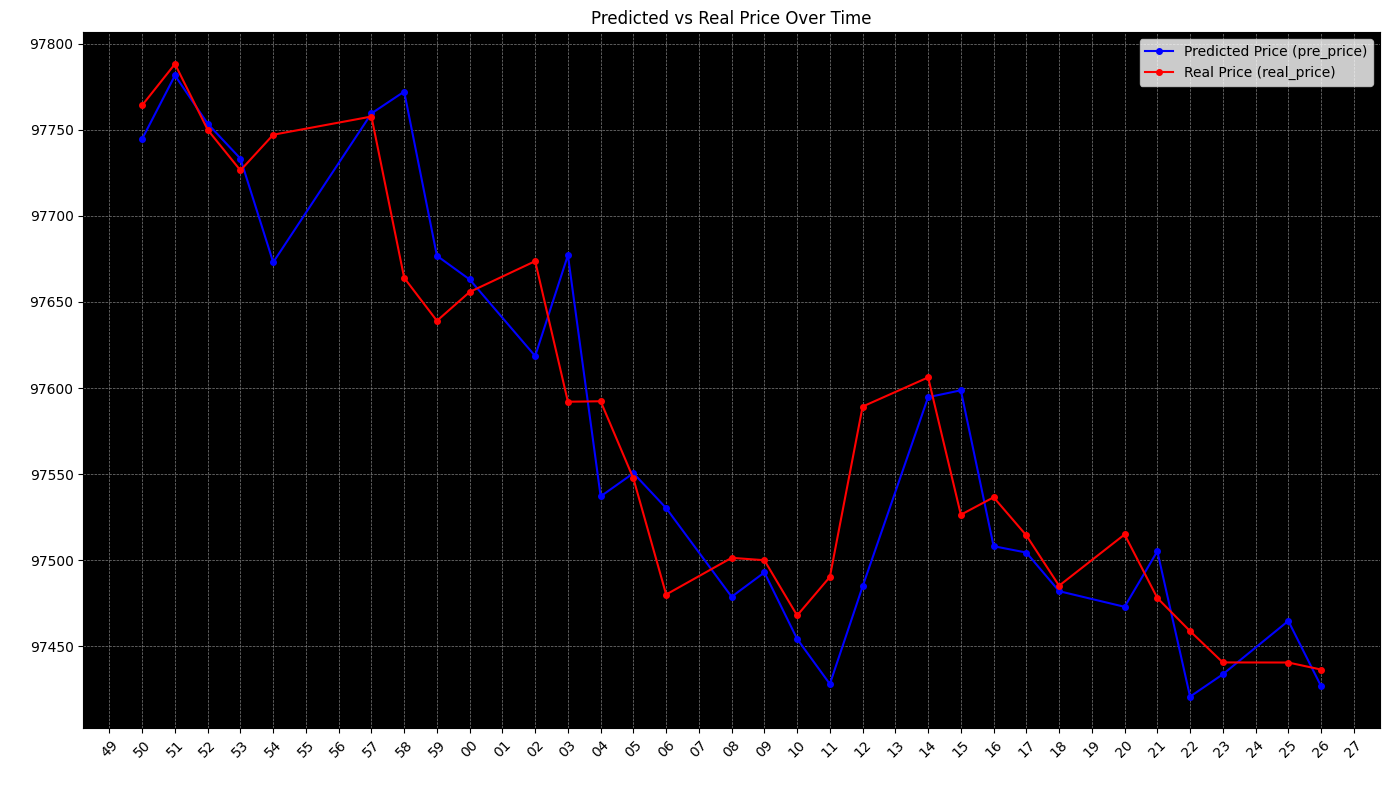

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
df_pre_6 = produce_predictions(model_12,scaled_prices)
plotting_predictions(df_pre_6[0:30], f"{model_12.name}.png")
model_12.save("deneme_model_12.h5")
files.download("deneme_model_12.h5")